In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
from scipy import stats
import networkx as nx
import seaborn as sns
import re
import sys
sys.path.append("../scripts/")
from nn_gaussian_noise import *

plt.style.use("../config/custom_plt.mplstyle")

plt.rc('text', usetex=False)

In [2]:
%%time 

dataset = 'MNIST'
hidden_size = [64]

num_samples_per_class = 100000

# Easy task
class1 = 0
class2 = 7

all_original_acc_easy = []
all_results_easy = []

activation_fn = '_relu'
activation_fn = '_sigmoid'

for i in range(20):
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/'
    original_acc_easy, results_easy = gaussian_noise_mlp(9, path, [class1, class2], num_samples_per_class,
                                         hidden_size, verbose=False)
    
    all_original_acc_easy.append(original_acc_easy)
    all_results_easy.append(results_easy)

100%|██████████| 30/30 [01:26<00:00,  2.88s/it]

CPU times: user 18h 30min 3s, sys: 17 s, total: 18h 30min 20s
Wall time: 28min 38s


In [3]:
%%time

# Hard task
class1 = 7
class2 = 9

all_original_acc_hard = []
all_results_hard = []

for i in range(20):
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/'
    original_acc_hard, results_hard = gaussian_noise_mlp(9, path, [class1, class2], num_samples_per_class,
                                                         hidden_size, verbose=False)
    all_original_acc_hard.append(original_acc_hard)
    all_results_hard.append(results_hard)

100%|██████████| 30/30 [01:20<00:00,  2.69s/it]

CPU times: user 18h 21min 32s, sys: 16.2 s, total: 18h 21min 48s
Wall time: 28min 21s


In [4]:
hidden_size = [64] # 64

std_weights_hard = []
std_weights_easy = []

for i in range(20):
    class1 = 7
    class2 = 9
    weights_hard = []
    
    # Layer 0
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/epoch_9_Layer0_edgelist.txt'    
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_hard.append(float(line.split()[-1]))
    # Layer 1
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/epoch_9_Layer1_edgelist.txt'    
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_hard.append(float(line.split()[-1]))

    
    class1 = 0
    class2 = 7
    weights_easy = []
    
    # Layer 0
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/epoch_9_Layer0_edgelist.txt'
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_easy.append(float(line.split()[-1]))
    
    # Layer 1
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/epoch_9_Layer1_edgelist.txt'
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_easy.append(float(line.split()[-1]))

            
    std_weights_hard.append(np.std(weights_hard))
    std_weights_easy.append(np.std(weights_easy))

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shaded_area(x, data, plot_style='median_iqr', label='', color='blue', alpha=0.2, linestyle='-'):
    """
    Plots a shaded area with a central line based on the provided data.
    
    Parameters:
      x (array-like): x-axis values.
      data (np.ndarray): 2D array where each row corresponds to a run.
      plot_style (str): 'mean_std' for mean ± standard deviation,
                        'median_iqr' for median with interquartile range.
      label (str): Label for the central line.
      color (str): Color for the shaded area and line.
      alpha (float): Transparency for the shaded area.
    """
    if plot_style == 'mean_std':
        central = np.mean(data, axis=0)
        lower = central - np.std(data, axis=0)
        upper = central + np.std(data, axis=0)
    elif plot_style == 'median_iqr':
        central = np.median(data, axis=0)
        lower = np.percentile(data, 25, axis=0)
        upper = np.percentile(data, 75, axis=0)
    else:
        raise ValueError("Unsupported plot_style. Use 'mean_std' or 'median_iqr'.")
        
    plt.fill_between(x, lower, upper, alpha=alpha, color=color)
    plt.plot(x, central, color=color, label=label, linestyle=linestyle)

def extract_values(results, index):
    """
    Extracts values from a list of dictionaries.
    
    Parameters:
      results (list): List of dictionaries with values as iterables.
      index (int): The index to extract from each value tuple.
      
    Returns:
      np.ndarray: 2D array with extracted values.
    """
    vals = []
    for r in results:
        vals.append([x[index] for x in r.values()])
    return np.array(vals)


# Compute the x-axis values (fraction of remaining edges)
# x = np.array(list(all_results_easy[0].keys()))  # x-axis: fraction of removed edges

# plt.figure(figsize=(11, 6))

# # ----------------- Easy Task -----------------
# plt.subplot(1, 2, 1)
# # Plot baseline accuracy for the easy task
# plt.fill_between(x, np.percentile(all_original_acc_easy, 25), np.percentile(all_original_acc_easy, 75),
#                  color='black', alpha=0.2)
# plt.axhline(np.median(all_original_acc_easy), linestyle='--', color='black')

# # Plot "original" values using mean and standard deviation
# vals_original_easy = extract_values(all_results_easy, 0)
# plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='original', color='xkcd:royal blue')

# # Plot "signed" values using mean and standard deviation
# vals_signed_easy = extract_values(all_results_easy, 1)
# plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='signed', color='xkcd:orange')

# plt.axvline(np.median(std_weights_easy), linestyle='-.', color='green', label=r'$\overline{\sigma(w)}$')

# plt.legend(loc=(0.01, 0.05))
# plt.title(f'Easy task ')
# plt.ylabel('Accuracy')
# plt.xscale('log')
# # plt.xlabel('$\sigma$, gaussian noise')
# plt.xlabel('$a$, uniform noise U(-a,a)')
# plt.ylim(48, 102)

# # ----------------- Hard Task -----------------
# plt.subplot(1, 2, 2)
# # Plot baseline accuracy for the hard task
# plt.fill_between(x, np.percentile(all_original_acc_hard, 25), np.percentile(all_original_acc_hard, 75),
#                  color='black', alpha=0.2)
# plt.axhline(np.median(all_original_acc_hard), linestyle='--', color='black')

# # Plot "original" values using mean and standard deviation
# vals_original_hard = extract_values(all_results_hard, 0)
# plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='original', color='xkcd:royal blue')

# # Plot "signed" values using median and interquartile range (IQR)
# vals_signed_hard = extract_values(all_results_hard, 1)
# plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='signed', color='xkcd:orange')

# plt.axvline(np.median(std_weights_hard), linestyle='-.', color='green', label=r'$\overline{\sigma(w)}$')
# # plt.legend()

# plt.ylim(48, 102)
# plt.xscale('log')
# # plt.xlabel('$\sigma$, gaussian noise')
# plt.xlabel('$a$, uniform noise U(-a,a)')
# plt.title('Hard task')

# plt.suptitle(f"MNIST [{hidden_size[0]}]", fontsize=26)
# plt.tight_layout()

In [6]:
colors = ['#ef8a47', '#528fad']

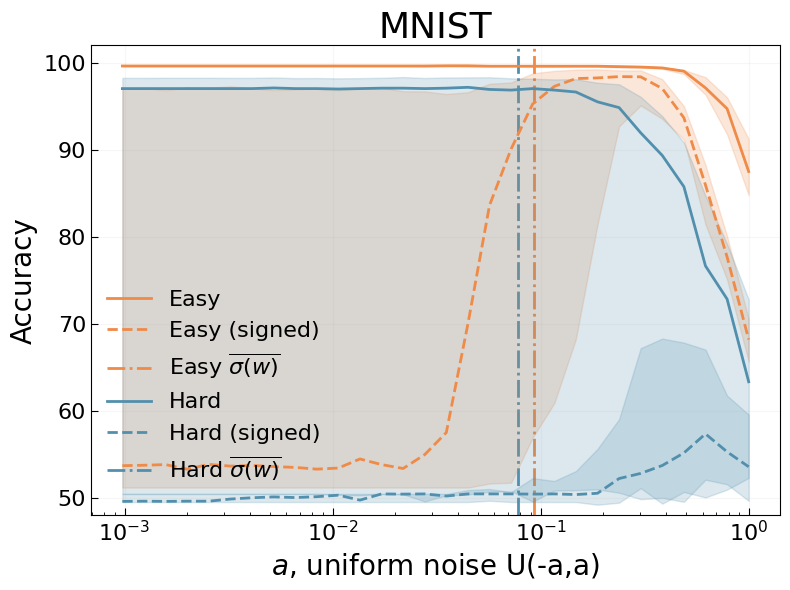

In [7]:
x = np.array(list(all_results_easy[0].keys()))  # x-axis: fraction of removed edges

# plt.fill_between(x, np.percentile(all_original_acc_easy, 25), np.percentile(all_original_acc_easy, 75),
#                  color='black', alpha=0.2)
# plt.axhline(np.median(all_original_acc_easy), linestyle='--', color='black')

# Plot "original" values using mean and standard deviation
vals_original_easy = extract_values(all_results_easy, 0)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Easy', color=colors[0])

# Plot "signed" values using mean and standard deviation
vals_signed_easy = extract_values(all_results_easy, 1)
plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='Easy (signed)', 
                 color=colors[0], linestyle='--')

plt.axvline(np.median(std_weights_easy), linestyle='-.', color=colors[0], label=r'Easy $\overline{\sigma(w)}$', zorder=-10)

# Plot baseline accuracy for the hard task
# plt.fill_between(x, np.percentile(all_original_acc_hard, 25), np.percentile(all_original_acc_hard, 75),
#                  color='black', alpha=0.2)
# plt.axhline(np.median(all_original_acc_hard), linestyle='--', color='black')

# Plot "original" values using mean and standard deviation
vals_original_hard = extract_values(all_results_hard, 0)
plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='Hard', color=colors[1])

# Plot "signed" values using median and interquartile range (IQR)
vals_signed_hard = extract_values(all_results_hard, 1)
plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='Hard (signed)', color=colors[1],
                linestyle='--')

plt.axvline(np.median(std_weights_hard), linestyle='-.', color=colors[1], label=r'Hard $\overline{\sigma(w)}$', zorder=-10)

plt.legend(loc=(0.01, 0.05))
plt.ylabel('Accuracy')
plt.xscale('log')
# plt.xlabel('$\sigma$, gaussian noise')
plt.xlabel('$a$, uniform noise U(-a,a)')
plt.ylim(48, 102)

plt.title(f"MNIST", fontsize=26)
plt.tight_layout()

# plt.savefig("../plots/paper/noise_mnist_d64.pdf")
# plt.savefig("../plots/paper/noise_mnist_d32.pdf")
# plt.savefig("../plots/paper/noise_mnist_d128.pdf")

# plt.savefig("../plots/paper/noise_mnist_d64_sigmoid.pdf")